### Imports and path setting

In [2]:
from data_reader import Vocabulary, HWDBDatasetHelper, ArchivedHWDBReader

train_path = './Images_train.zip'
test_path = './Images_test.zip'

gt_path = './gt.txt'
pred_path = './pred.txt'

In [3]:
import os
import random
import math

import numpy as np
import cv2

### Data tools

In [4]:
train_reader = ArchivedHWDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [5]:
train_helper, val_helper = train_helper.train_val_split()

In [6]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [7]:
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch.nn import Parameter
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224)) / 255.
        img = np.moveaxis(img, -1, 0)
        img = normalize(torch.tensor(img, dtype=torch.float32))
        return img, label

In [8]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

In [9]:
img, label = train_dataset[20]

In [10]:
img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


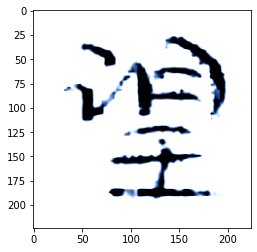

In [11]:
import matplotlib.pyplot as plt

plt.imshow(np.moveaxis(img.numpy(), 0, -1))

### ArcFace loss

In [12]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output

### MobilenetV3 with ArcFace loss

In [28]:
import torchvision.models as models

model = models.mobilenet_v3_small(pretrained=True)

In [29]:
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

In [30]:
model(torch.tensor(train_dataset[0][0], dtype=torch.float32).view(1, 3, 224, 224)).size()

C:\Users\user\AppData\Local\Temp/ipykernel_12860/3990179690.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model(torch.tensor(train_dataset[0][0], dtype=torch.float32).view(1, 3, 224, 224)).size()


torch.Size([1, 1000])

In [31]:
model = model.cuda()

In [32]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [33]:
classes = train_helper.vocabulary.num_classes()
print(classes)

7330


In [34]:
metric_fc = ArcMarginProduct(1000, classes).cuda()

In [35]:
optim = torch.optim.Adam([{'params': model.parameters()}, {'params': metric_fc.parameters()}], lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [36]:
from tqdm import tqdm


def run_validation(val_loader: DataLoader, model: nn.Module, n_steps=None):
    model.eval()
    n_good = 0
    n_all = 0
    wrapper = lambda x: x
    if n_steps is None:
        n_steps = len(val_loader)
        wrapper = tqdm
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(wrapper(val_loader)):
            if batch == n_steps:
                break
            y = y.to(torch.long).cuda()
            features = model(X.to(torch.float32).cuda())
            logits = metric_fc(features, y)
            classes = torch.argmax(logits, dim=1).cpu().numpy()
            n_good += sum(classes == y.cpu().numpy())
            n_all += len(classes)
    
    return n_good / n_all


def train_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn):
    for batch, (X, y) in enumerate(tqdm(train_loader)):
        y = y.to(torch.long).cuda()
        model.train()
        features = model(X.to(torch.float32).cuda())
        logits = metric_fc(features, y)
        loss = loss_fn(logits, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

In [37]:
# torch.save(model.state_dict(), 'model.pth')

In [38]:
for epoch in range(3):
    print(f'Epoch {epoch}:')
    train_epoch(train_loader, val_loader, model, optim, loss_fn)
    accuracy = run_validation(val_loader, model)
    print(f'accuracy: {accuracy}')
    torch.save(model.state_dict(), f'model_epoch{epoch}.pth')

Epoch 0:


100%|██████████████████████████████████████████████████████████████████████████████| 2519/2519 [27:58<00:00,  1.50it/s]


accuracy: 0.0
Epoch 1:


100%|██████████████████████████████████████████████████████████████████████████████| 2519/2519 [25:04<00:00,  1.67it/s]


accuracy: 0.0
Epoch 2:


100%|██████████████████████████████████████████████████████████████████████████████| 2519/2519 [24:26<00:00,  1.72it/s]

accuracy: 0.0


### Class embeddings gathering

In [56]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, drop_last=True)

In [57]:
embeddings = {}
classes_found = 0

model.eval()
with torch.no_grad():
    for X, y in tqdm(train_loader):
        y = y.item()
        if y not in embeddings:
            embedding = model(X.to(torch.float32).cuda()).squeeze()
            embeddings[y] = embedding
            classes_found += 1
            if classes_found == classes:
                break

  5%|███▋                                                                  | 134494/2578433 [04:36<1:23:37, 487.10it/s]


In [58]:
len(embeddings.keys())

7330

In [60]:
embeddings[822].shape

torch.Size([1000])

### Evaluation

In [61]:
test_reader = ArchivedHWDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [62]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [65]:
def get_predictions(model, test_dataloader, embeddings):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    model.eval()
    predictions = []

    with torch.no_grad():
        for i, (X, _) in enumerate(tqdm(test_dataloader)):
            output = model(X.to(torch.float32).cuda()).squeeze()
            best_class = None
            best_sim = float('-inf')
            for curr_class, curr_emb in embeddings.items():
                curr_sim = cos(output, curr_emb)
                if curr_sim > best_sim:
                    best_sim = curr_sim
                    best_class = curr_class

            predictions.append(best_class)
            
            if i == 50:
                break
    
    return predictions

In [66]:
preds = get_predictions(model, test_loader, embeddings)

  0%|                                                                          | 50/776523 [01:14<323:21:28,  1.50s/it]


In [68]:
preds[0]

3639

In [69]:
with open(pred_path, 'w', encoding='utf-8') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        line = name + ' ' + cls
        print(line, file=f_pred)

In [ ]:
from pathlib import Path

def evaluate(gt_path, pred_path):
    gt = dict()
    with open(gt_path, mode='r', encoding='utf-8') as gt_f:
        for line in gt_f:
            name, cls = line.strip().split()
            gt[name] = cls
    
    n_good = 0
    n_all = len(gt)
    with open(pred_path, mode='r', encoding='utf-8') as pred_f:
        for line in pred_f:
            name, cls = line.strip().split()
            if cls == gt[name]:
                n_good += 1
    
    return n_good / n_all

score = evaluate(gt_path, pred_path)
print('Accuracy = {:1.4f}'.format(score))